In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from glob import glob
import joblib

/common/home/qd57/anaconda3/envs/dpgen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        
        self.Linear1 = nn.Linear(256*14*14, 64)
        self.Linear2 = nn.Linear(64, 2)
                
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)

        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)

In [4]:
model = MultiClassifier()

In [5]:
model.load_state_dict(torch.load('./celeba_cls.pth'))

<All keys matched successfully>

In [6]:
model = model.cuda()

In [7]:
# base = 'exp/image_samples/1020_MNIST_EXP_EXP2_K2_IMAGE_SIZE_28_BATCH_128_TWCII/'
# base = 'exp/image_samples/1020_MNIST_EXP_EXP10_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'
# base = 'exp/image_samples/1023_MNIST_EXP_EXPINF_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/1023_FashionMNIST_EXP_EXPINF_K5_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/1109_FashionMNIST_EXP_EXP02_K2_IMAGE_SIZE_28_BATCH_128_TWCII/'

# base = 'exp/image_samples/xxxx_CELEBA_EXP_EXP02_K2_IMAGE_SIZE_128_BATCH_4_TWCII/'

# should be changed to the path of generated celeba data
base = '/data/local/qipan/exp_celeba/datasets/celeba/celeba/img_align_celeba' 

In [8]:
images = glob(base + '/*')

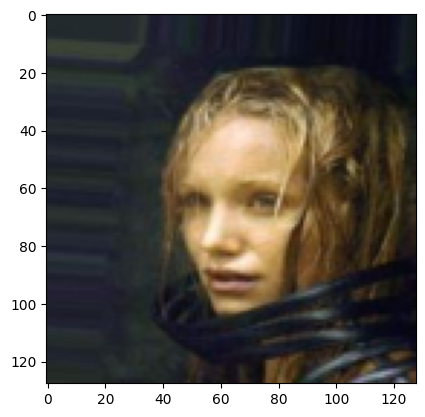

In [9]:
x = Image.open(images[6])

transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# transform=transforms.Compose([
#     transforms.ToTensor()
# ])

x = transform(x)

plt.imshow(x.permute(1,2,0))

In [10]:
x.shape

torch.Size([3, 128, 128])

In [11]:
model(x.unsqueeze(0).cuda())

/common/home/qd57/anaconda3/envs/dpgen/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/tmp/ipykernel_2342488/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor([[0.2347, 0.7653]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [12]:
train_x = []
train_y = []

In [13]:
from time import time

In [16]:
st = time()

for ix, img in enumerate(images):
    if ix % 1000 == 0:
        print(ix, time() - st)
        
    x = transform(Image.open(img))
    pred_y = model(x.unsqueeze(0).cuda())
    
    np_x = x.cpu().numpy()
    np_y = torch.round(pred_y).cpu().detach().numpy()[0]
    
    train_x.append(np_x)
    train_y.append(np_y)

    # if ix>10000:
    #     break
    

0 8.7738037109375e-05


/tmp/ipykernel_2342488/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


1000 2.1415724754333496
2000 4.753082275390625
3000 6.688617467880249
4000 9.301917314529419
5000 11.225685358047485
6000 13.451518535614014
7000 15.305670261383057
8000 17.139424085617065
9000 19.200489044189453
10000 21.523709297180176


In [17]:
import numpy as np

In [18]:
yy = [np.argmax(y) for y in train_y]

In [19]:
np.unique(yy, return_counts=True)

(array([0, 1]), array([31349, 23231]))

In [20]:
joblib.dump(train_x, './train_celeba_x_exp_fake.pkl')
joblib.dump(train_y, './train_celeba_y_exp_fake.pkl')

['./train_celeba_y_exp_fake.pkl']